# Set-Up

In [1]:
import os

from PIL import Image, ImageDraw, ImageOps, ImageFont
from tqdm.notebook import trange, tqdm
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from torch import nn
import torch
#from yolov5.models.common import DetectMultiBackend
import yaml
import numpy as np
import cv2
from itertools import groupby
from torchvision.ops import nms
import math
from Levenshtein import ratio
import numpy as np


def prep_image_for_detection(image, imgsz=1024):
    coef = min(imgsz / image.shape[0], imgsz / image.shape[1])
    image_ = cv2.resize(image.copy(), dsize=None, fx=coef, fy=coef, interpolation=cv2.INTER_CUBIC)
    image_ = cv2.copyMakeBorder(image_, 0, imgsz-image_.shape[0], 0, imgsz-image_.shape[1], cv2.BORDER_CONSTANT, value=(255, 255, 255))

    image_ = torch.FloatTensor(image_) / 255
    image_ = torch.permute(image_, (2, 0, 1)).unsqueeze(0)

    return image_, coef


def non_max_suppression_fast(boxes, overlapThresh):
    if len(boxes) == 0:
        return []
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    pick = []

    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)

    idxs = np.arange(boxes.shape[0])

    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))
        # return only the bounding boxes that were picked using the
        # integer data type
    return boxes[pick].astype("int")


def get_boxes(model, image):
    image_, scale = prep_image_for_detection(image)
    H, W = image.shape[:2]

    output = model(image_)
    output = output.detach().cpu().numpy()[0]

    boxes = list()

    output = output[output[:, 4] > 0.25]

    output[:, 5:] *= output[:, 4:5]

    output[:, 0] = (output[:, 0] - output[:, 2] / 2)  # xc to top left x
    output[:, 1] = (output[:, 1] - output[:, 3] / 2)  # yc to top left y

    output[:, :4] /= scale

    for detection in output:
        x, y, w, h = detection[:4]

        conf = detection[4]
        class_ohe = detection[5:]

        boxes.append([x, y, w, h, conf, np.argmax(class_ohe)])

    boxes = np.array(boxes)
    boxes[(boxes[:, 2] > 0) & (boxes[:, 3] > 0)]
    confs = boxes[:, 4]
    cls = boxes[:, 5]
    boxes = boxes[:, :4]

    nmsstart = time.time()
    boxes = boxes[np.argsort(confs)]

    xyxy_boxes = boxes.copy()
    xyxy_boxes[:, 2] += xyxy_boxes[:, 0]
    xyxy_boxes[:, 3] += xyxy_boxes[:, 1]

    xyxy_boxes = non_max_suppression_fast(xyxy_boxes, 0.25)
    boxes = xyxy_boxes.copy()
    boxes[:, 2] -= boxes[:, 0]
    boxes[:, 3] -= boxes[:, 1]

    # print('nms time:', time.time()-nmsstart)

    boxes = np.maximum(boxes, 0)
    boxes[:, 0] = np.minimum(boxes[:, 0], image.shape[1])
    boxes[:, 1] = np.minimum(boxes[:, 1], image.shape[0])
    boxes[:, 2] = np.minimum(boxes[:, 2], image.shape[1]-boxes[:, 0])
    boxes[:, 3] = np.minimum(boxes[:, 3], image.shape[0]-boxes[:, 1])

    boxes = np.round(boxes[:, :4]).astype(int)
    return boxes, confs, cls


def safe_convert_to_grayscale(image_to_convert):
    if len(image_to_convert.shape) == 2:
        return image_to_convert
    if len(image_to_convert.shape) == 3:
        if image_to_convert.shape[2] == 1:
            return image_to_convert[:, :, 0]
        if image_to_convert.shape[2] == 3:
            return cv2.cvtColor(image_to_convert, cv2.COLOR_BGR2GRAY)
        if image_to_convert.shape[2] == 4:
            return cv2.cvtColor(image_to_convert, cv2.COLOR_BGRA2GRAY)

    raise ValueError('invalid shape')


def decode_texts(logits, alphabet, blank_idx):
    if blank_idx < 0:
        blank_idx = len(alphabet)
    best_path_indices = np.argmax(logits, axis=-1)
    best_chars_collapsed = [[alphabet[idx-(idx >= blank_idx)] for idx, _ in groupby(e) if idx != blank_idx and idx < len(alphabet)]
                            for e in best_path_indices]
    return [''.join(e) for e in best_chars_collapsed]


def prepare_segment_for_recognition(segment, target_shape=(32, 256)):
    segment = safe_convert_to_grayscale(segment)

    coef = min(target_shape[0] / segment.shape[0], target_shape[1] / segment.shape[1])

    segment = cv2.resize(segment, dsize=None, fx=coef, fy=coef, interpolation=cv2.INTER_AREA if coef < 1 else cv2.INTER_CUBIC)
    segment = cv2.copyMakeBorder(segment, 0, target_shape[0]-segment.shape[0], 0, target_shape[1]-segment.shape[1], cv2.BORDER_CONSTANT, value=(255, 255, 255))
    segment = torch.FloatTensor(segment / 255)

    return segment.unsqueeze(0).unsqueeze(0)


def recognize_text(model, image, boxes, alphabets, batch_size=64):
    result = list()
    segments = [image[y: y+h, x: x+w] for (x, y, w, h) in boxes]
    segments = [prepare_segment_for_recognition(segment) for segment in segments]
    segments = torch.cat(segments, axis=0)

    for i in range(1, segments.shape[0] // batch_size + (segments.shape[0] % batch_size != 0) + 1):
        with torch.no_grad():
            y_text, y_script = model(segments[(i-1)*batch_size: i*batch_size])
        rus_indices = np.where(y_script.argmax(-1).numpy() == 0)
        eng_indices = np.where(y_script.argmax(-1).numpy() == 1)

        rus_texts = decode_texts(y_text[rus_indices].cpu().numpy(), alphabets[0], blank_idx=0)
        eng_texts = decode_texts(y_text[eng_indices].cpu().numpy(), alphabets[1], blank_idx=0)

        output = list()
        ridx = 0
        eidx = 0

        for idx in y_script.argmax(-1):
            if idx == 0:
                output.append(rus_texts[ridx])
                ridx += 1
            else:
                output.append(eng_texts[eidx])
                eidx += 1

        result.extend(output)

    return result


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool_ksize=(2, 2)):
        super(ConvBlock, self).__init__()

        self.block = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                   nn.LeakyReLU(0.1),
                                   nn.BatchNorm2d(out_channels),
                                   nn.MaxPool2d(pool_ksize))

    def forward(self, x):
        return self.block(x)


class ResidualConvBlock2d(nn.Module):
    def __init__(self, in_channels, out_channels, pool_ksize=(2, 2)):
        super(ResidualConvBlock2d, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(pool_ksize)
        self.lrelu = nn.LeakyReLU(0.1)

        self.identity_conv = nn.Conv2d(in_channels, out_channels, 1, stride=pool_ksize)

    def forward(self, x):
        e = self.conv1(x)
        e = self.lrelu(e)
        e = self.bn1(e)
        e = self.conv2(e)
        e = self.lrelu(e)
        e = self.bn2(e)
        
        e = self.pool(e)
        
        return self.identity_conv(x) + e


class ResidualConvBlock1d(nn.Module):
    def __init__(self, in_channels, out_channels, pool_ksize=2):
        super(ResidualConvBlock1d, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv1d(out_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.pool = nn.MaxPool1d(pool_ksize)
        self.lrelu = nn.LeakyReLU(0.1)

        self.identity_conv = nn.Conv1d(in_channels, out_channels, 1, stride=pool_ksize)

    def forward(self, x):
        e = self.conv1(x)
        e = self.lrelu(e)
        e = self.bn1(e)
        e = self.conv2(e)
        e = self.lrelu(e)
        e = self.bn2(e)
        e = self.pool(e)

        return self.identity_conv(x) + e


class ScriptClassificationModel(nn.Module):
    def __init__(self, nscripts, input_shape):
        super(ScriptClassificationModel, self).__init__()

        self.feature_extractor = nn.Sequential(nn.Conv1d(input_shape[0], input_shape[0]//2, 4),
                                               nn.LeakyReLU(0.1),
                                               nn.BatchNorm1d(input_shape[0]//2),
                                               nn.MaxPool1d(4),
                                              
                                               nn.Conv1d(input_shape[0]//2, input_shape[0]//4, 4),
                                               nn.LeakyReLU(0.1),
                                               nn.BatchNorm1d(input_shape[0]//4),
                                               nn.MaxPool1d(4))

        self.feature_extractor = nn.Sequential(ResidualConvBlock1d(input_shape[0], input_shape[0], 2),
                                               ResidualConvBlock1d(input_shape[0], input_shape[0]//2, 2),
                                               ResidualConvBlock1d(input_shape[0]//2, input_shape[0]//2, 2),
                                               ResidualConvBlock1d(input_shape[0]//2, input_shape[0]//4, 2),
                                               ResidualConvBlock1d(input_shape[0]//4, input_shape[0]//4, 2))

        self.fc = nn.Sequential(nn.Linear(64, nscripts),
                                nn.Softmax(dim=-1))

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view((x.shape[0], -1))

        x = self.fc(x)

        return x


class RecognitionHead(nn.Module):
    def __init__(self, alphabet_len):
        super(RecognitionHead, self).__init__()
        
        self.rnn1 = nn.RNN(256, 256, batch_first=True)
        self.rnn2 = nn.RNN(256, 256, batch_first=True)

        self.fc = nn.Sequential(nn.Linear(256, 128),
                                nn.ReLU(),
                                nn.Linear(128, alphabet_len+1),
                                nn.Softmax(dim=2))

    def forward(self, x):
        x = torch.permute(x, (0, 2, 1))
        
        x, _ = self.rnn1(x, None)
        x, _ = self.rnn2(x, None)
        x = self.fc(x)

        return x


class MCRNN(nn.Module):
    def __init__(self, alphabet_lens):
        super(MCRNN, self).__init__()

        self.feature_extractor = nn.Sequential(ResidualConvBlock2d(1, 16),
                                               ResidualConvBlock2d(16, 32, (2, 1)),
                                               ResidualConvBlock2d(32, 64),
                                               ResidualConvBlock2d(64, 128),
                                               ResidualConvBlock2d(128, 256, (2, 1)))

        self.script_classifier = ScriptClassificationModel(len(alphabet_lens), (256, 32))

        self.recognition_heads = nn.ModuleList([RecognitionHead(max(alphabet_lens)) for _ in alphabet_lens])

        self.output_dim = max(alphabet_lens) + 1

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x):
        x = self.feature_extractor(x).squeeze(2)

        script_probs = self.script_classifier(x)
        script_indices = script_probs.argmax(-1)
        
        output = torch.zeros((x.shape[0], x.shape[2], self.output_dim), device=self.device)

        for sidx in torch.unique(script_indices):
            output[script_indices == sidx] = self.recognition_heads[sidx](x[script_indices == sidx])

        return output, script_probs


def order_boxes(boxes):
    def contour_dist(box1, box2):
        def axiswise_dist(s1, s2):
            """
            s = (left coord, right coord)
            """
            left = min(s1, s2, key=lambda x: x[0])
            right = max(s1, s2, key=lambda x: x[0])

            return max(0, right[0] - left[1])

        delta_x = axiswise_dist((box1[0], box1[0] + box1[2]), (box2[0], box2[0] + box2[2]))
        delta_y = axiswise_dist((box1[1], box1[1] + box1[3]), (box2[1], box2[1] + box2[3]))

        if delta_x == delta_y == 0:
            return 0
        if min(delta_x, delta_y) == 0 and max(delta_x, delta_y) > 0:
            return max(delta_x, delta_y)
        return math.sqrt(delta_x * delta_x + delta_y * delta_y)

    y_sorted_boxes = np.array(sorted(boxes.copy(), key=lambda x: x[1]), dtype='int64')
    indices = np.array([i for i, box in sorted(enumerate(boxes.copy()), key=lambda x:x[1][1])])

    epsilon = np.mean(boxes[:, 3])

    cluster_labels = np.full((len(y_sorted_boxes, )), fill_value=-1)

    cluster_labels[0] = 0

    for i in range(len(y_sorted_boxes)):
        if cluster_labels[i] == -1:
            cluster_labels[i] = max(cluster_labels) + 1
        for j in range(len(y_sorted_boxes)):
            if contour_dist(y_sorted_boxes[i], y_sorted_boxes[j]) < epsilon:
                min_l = min(cluster_labels[i], cluster_labels[j])
                max_l = max(cluster_labels[i], cluster_labels[j])
                if min_l == -1:
                    cluster_labels[i] = max_l
                    cluster_labels[j] = max_l
                    continue
                cluster_labels[cluster_labels == max_l] = min_l

    cluster_labels = np.array(cluster_labels)

    sorted_boxes = list()
    sorted_indices = list()
    for c in np.unique(cluster_labels):
        cluster_boxes = y_sorted_boxes[cluster_labels == c]
        cluster_indices = indices[cluster_labels == c]
        
        group = [cluster_boxes[0]]
        indices_group = [cluster_indices[0]]
        for i in range(1, len(cluster_boxes)):
            if abs(cluster_boxes[i][1] - cluster_boxes[i - 1][1]) < (epsilon*0.5):
                group.append(cluster_boxes[i])
                indices_group.append(cluster_indices[i])
            else:
                sorted_boxes.extend(sorted(group, key=lambda x: x[0]))
                sorted_indices.extend([indices_group[i] for i, box in sorted(enumerate(group), key=lambda x: x[1][0])])
                
                group = [cluster_boxes[i]]
                indices_group = [cluster_indices[i]]
                
        sorted_boxes.extend(sorted(group, key=lambda x: x[0]))
        sorted_indices.extend([indices_group[i] for i, box in sorted(enumerate(group), key=lambda x: x[1][0])])

    sorted_boxes = np.array([np.array(box) for box in sorted_boxes])
    return np.array(sorted_indices), sorted_boxes


def calc_iou(box1: np.ndarray, box2: np.ndarray) -> float:
    intersection_area = calc_intersection_area(box1, box2)

    return intersection_area / (box1[2] * box1[3] + box2[2] * box2[3] - intersection_area)


def calc_intersection_area(box1, box2):
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[0] + box1[2], box2[0] + box2[2])
    yB = min(box1[1] + box1[3], box2[1] + box2[3])
    intersection_area = max(0, xB - xA) * max(0, yB - yA)

    return intersection_area


def evaluate_ocr_result(gt_boxes, pred_boxes, gt_words, pred_words, iou_thr=0.5):
    TP = 0
    FP = 0
    FN = 0

    matched_indices = list()
    used_boxes_mask = np.zeros((pred_boxes.shape[0],), dtype=bool)
    for i, gt_box in enumerate(gt_boxes):
        best_iou = 0
        best_idx = None
        for j, pred_box in enumerate(pred_boxes):
            pred_box = pred_box.ravel()
            gt_box = pred_box.ravel()
            if used_boxes_mask[j]:
                continue   
            iou = calc_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_idx = j

        if best_iou > iou_thr:
            matched_indices.append((i, best_idx))
            used_boxes_mask[best_idx] = 1
            TP += 1
        else:
            FN += 1

    FP = used_boxes_mask.shape[0] - sum(used_boxes_mask)
    
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    
    f1_score = 2*precision*recall/(precision+recall)

    return precision, recall, f1_score

In [3]:

device = torch.device('cpu')

# detection_model_weights = './detection/yolov5/runs/train/yolov5m no slicing 0.6/weights/best.pt'
detection_model_weights = '/home/vshishaev/ocr_engine/best_with_docbank_2204.pt'
detection_model = torch.hub.load('./yolov5', 'custom', path=detection_model_weights, source='local') 
#print(model(torch.randn(1,3,640,640)))
#detection_model = DetectMultiBackend(detection_model_weights, device=device, dnn=False)
detection_model.eval()

alphabets = ['ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЬЫЪЭЮЯ 0123456789!@№%?()-=+.,/«»:;~"<>[]', 'ABCDEFGHIJKLMNOPRSTUVWXYZ 0123456789!@№%?()-=+.,/«»:;~"<>[]']
recognition_model_weights = '/home/vshishaev/mcrnn_engine/multilingual_crnn_rt_2506l.pth'
recognition_model = MCRNN([len(a) for a in alphabets])
recognition_model.load_state_dict(torch.load(recognition_model_weights, map_location=device))
recognition_model.eval();

WARNING ⚠️ torchvision==0.10 is incompatible with torch==2.0.
Run 'pip install torchvision==0.15' to fix torchvision or 'pip install -U torch torchvision' to update both.
For a full compatibility table see https://github.com/pytorch/vision#installation
requirements: Ultralytics requirement ['requests>=2.32.0'] not found, attempting AutoUpdate...
Defaulting to user installation because normal site-packages is not writeable

requirements: AutoUpdate success ✅ 1.1s, installed 1 package: ['requests>=2.32.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 v7.0-333-gb9019671 Python-3.9.19 torch-2.0.0.post200 CUDA:0 (NVIDIA GeForce RTX 3060, 12044MiB)

Fusing layers... 
YOLOv5m summary: 212 layers, 20861016 parameters, 0 gradients
Adding AutoShape... 


In [4]:

def unnormalize_box(result):
  value = result['value']
  w, h = result['original_width'], result['original_height']

  if all([key in value for key in ['x', 'y', 'width', 'height']]):
    x0, y0 = w * value['x'] / 100.0, h * value['y'] / 100.0
    # x1, y1 = x0 + w * value['width'] / 100.0, y0 + h * value['height'] / 100.0
    w, h = w * value['width'] / 100.0, h * value['height'] / 100.0
    return [x0, y0, w, h]


def format_data_from_anns(receipt_ann, ds_path, label2id):
  formatted_ex = {}

  image_name = receipt_ann['data']['ocr'].split('%5C')[1]

  if os.path.exists(os.path.join(ds_path, image_name)):
    pil_im = Image.open(os.path.join(ds_path, image_name))
    pil_im = ImageOps.exif_transpose(pil_im)
    image_np = np.array(pil_im)
    # for sorting purposes :)
    formatted_ex['image_name'] = image_name  
      
    formatted_ex['image'] = image_np

    formatted_ex['boxes'] = np.array([unnormalize_box(ann) for ann in receipt_ann['annotations'][0]['result'] if ann['type'] == 'rectangle'], dtype=np.uint32)
    # sorting boxes and accordingly to them words, ner_tags for better training
    permutation, formatted_ex['boxes'] = order_boxes(formatted_ex['boxes'])
      
    formatted_ex['words'] = [ann['value']['text'] for ann in receipt_ann['annotations'][0]['result'] if ann['type'] == 'textarea']
    formatted_ex['words'] = np.squeeze(np.array(formatted_ex['words']))
    formatted_ex['words'] = np.array([formatted_ex['words'][i] for i in permutation])
      
    formatted_ex['ner_tags'] = [label2id[ann['value']['labels'][0]] for ann in receipt_ann['annotations'][0]['result'] if ann['type'] == 'labels']
    formatted_ex['ner_tags'] = np.squeeze(np.array(formatted_ex['ner_tags']))
    formatted_ex['ner_tags'] = np.array([formatted_ex['ner_tags'][i] for i in permutation])

    assert len(formatted_ex['boxes']) == len(formatted_ex['words']) == len(formatted_ex['ner_tags']) == len(permutation)
      
    return formatted_ex
      
  else:
    # print(image_name)
    return None


def get_third_dim(ds_image):
  return np.dstack((ds_image, ds_image, ds_image))


# removing fourth dimension for  png images
def remove_fourth_dim(ds_image):
  return ds_image[:,:,:3]

In [5]:
from transformers import LayoutLMv2ForTokenClassification
from transformers import LayoutXLMProcessor

import warnings
import contextlib

import requests
from urllib3.exceptions import InsecureRequestWarning

old_merge_environment_settings = requests.Session.merge_environment_settings

@contextlib.contextmanager
def no_ssl_verification():
    opened_adapters = set()

    def merge_environment_settings(self, url, proxies, stream, verify, cert):
        # Verification happens only once per connection so we need to close
        # all the opened adapters once we're done. Otherwise, the effects of
        # verify=False persist beyond the end of this context manager.
        opened_adapters.add(self.get_adapter(url))

        settings = old_merge_environment_settings(self, url, proxies, stream, verify, cert)
        settings['verify'] = False

        return settings

    requests.Session.merge_environment_settings = merge_environment_settings

    try:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', InsecureRequestWarning)
            yield
    finally:
        requests.Session.merge_environment_settings = old_merge_environment_settings

        for adapter in opened_adapters:
            try:
                adapter.close()
            except:
                pass

with no_ssl_verification():
    processor = LayoutXLMProcessor.from_pretrained("/home/vshishaev/layout_all/layout_checks/layoutXLM_sroie_rus_ordered_2805", apply_ocr=False)

device = torch.device('cpu')
clf_model = LayoutLMv2ForTokenClassification.from_pretrained("/home/vshishaev/layout_all/layout_checks/layoutXLM_sroie_rus_ordered_2805")
clf_model.to(device)

labels = ['O', 'B-COMPANY', 'I-COMPANY', 'B-DATE', 'I-DATE', 'B-ADDRESS',
          'I-ADDRESS', 'B-TOTAL', 'I-TOTAL']

id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}


def normalize_box_1000(box, height, width):

  x0, y0, x2, y2 = [int(p) for p in box]

  x0 = int(1000 * (x0 / width))
  x2 = int(1000 * (x2 / width))
  y0 = int(1000 * (y0 / height))
  y2 = int(1000 * (y2 / height))

  return [x0, y0, x2, y2]


def unnormalize_1000_box(bbox, width, height):
    return [
        int(width * (bbox[0] / 1000)),
        int(height * (bbox[1] / 1000)),
        int(width * (bbox[2] / 1000)),
        int(height * (bbox[3] / 1000)),
    ]

In [6]:
import json

annotations_path = '/home/vshishaev/layout_all/fixed_receipts_2506.json'
images_path = '/home/vshishaev/layout_all/all_images'

annotations = []

with open(annotations_path, 'r') as ann_f:
    annotations = json.load(ann_f)

clear_dataset = []

for ann in annotations:
    formatted_data = format_data_from_anns(ann, ds_path='/home/vshishaev/layout_all/val_split', label2id=label2id)
    if formatted_data is not None:
        clear_dataset.append(formatted_data)

for i, ex in enumerate(clear_dataset):
  if len(ex['image'].shape) == 2:
    clear_dataset[i]['image'] = get_third_dim(clear_dataset[i]['image'])

for i, ex in enumerate(clear_dataset):
  if ex['image'].shape[2] == 4:
    clear_dataset[i]['image'] = remove_fourth_dim(clear_dataset[i]['image'])

In [7]:
def match_boxes(gt_boxes, pred_boxes, iou_thr=0.5):

    matched_boxes_indices = list()
    used_boxes_mask = np.zeros((pred_boxes.shape[0],), dtype=bool)

    iou_thr = 0.5
    for i, (x1, y1, w, h) in enumerate(gt_boxes):
        best_iou = 0
        best_idx = None
        gt_box = x1, y1, w, h
        for j, (x1, y1, w, h) in enumerate(pred_boxes):
            if used_boxes_mask[j]:
                continue
            pred_box = x1, y1, w, h
            iou = calc_iou(pred_box, gt_box)
            if iou > best_iou:
                best_iou = iou
                best_idx = j

        if best_iou > iou_thr:
            matched_boxes_indices.append((i, best_idx))
            used_boxes_mask[j] = 1
            
    return matched_boxes_indices

# Calc Metrics on Validation

In [8]:
# forward for all validation examples

preds_labels_ids = []
gt_labels_ids = []

preds_word_label_tuples = []
gt_word_label_tuples = []


# put model in evaluation mode
clf_model.eval()
for idx in range(len(clear_dataset)):
    with torch.inference_mode():
        
        pred_boxes, confs, cls = get_boxes(detection_model, clear_dataset[idx]['image'])
        permutation, pred_boxes = order_boxes(pred_boxes)      
        pred_words = recognize_text(recognition_model, clear_dataset[idx]['image'], np.array(pred_boxes), alphabets, batch_size=32)
        
        width, height = clear_dataset[idx]['image'].shape[1], clear_dataset[idx]['image'].shape[0]
        norm_pred_boxes = []
        for i, box in enumerate(pred_boxes):
            
            x0, y0, x2, y2 = max(0, box[0]), max(0, box[1]), min(box[0]+box[2], width), min(box[1]+box[3], height)
            norm_pred_boxes.append( normalize_box_1000([x0, y0, x2, y2], height, width) )

        encoding = processor(clear_dataset[idx]['image'], text=pred_words, boxes=norm_pred_boxes, truncation=True,
                             return_offsets_mapping=True, return_tensors="pt",
                             padding="max_length", max_length=512)

        offset_mapping = encoding.pop('offset_mapping')

        for k, v in encoding.items():
            encoding[k] = v.to(device)

        outputs = clf_model(**encoding)

        predictions = outputs.logits.argmax(-1).squeeze().tolist()
        token_boxes = encoding.bbox.squeeze().tolist()

        input_ids = encoding['input_ids'].squeeze().tolist()
        is_subword = np.array(offset_mapping.squeeze().tolist())[:, 0] != 0

        pred_labels = [pred for i, pred in enumerate(predictions) if not is_subword[i]]
        layout_pred_boxes = np.array([unnormalize_1000_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]])

        for i, box in enumerate(layout_pred_boxes):
            x0, y0, w, h = box[0], box[1], box[2]-box[0], box[3]-box[1]
            layout_pred_boxes[i] = [x0, y0, w, h]

        pred_words = []
        word_idx = []
        for i in range(len(is_subword) - 1):
            word_idx.append(i)
            if is_subword[i + 1]:
              continue
            else:
                pred_words.append(''.join([processor.tokenizer.decode(input_ids[id]) for id in word_idx]))
                word_idx = []
        # adding end token
        pred_words.append('</s>')

        assert len(pred_words) == len(pred_labels)

        gt_boxes, gt_words, gt_labels = clear_dataset[idx]['boxes'].reshape(-1, 4), clear_dataset[idx]['words'], clear_dataset[idx]['ner_tags']

        layout_matched_boxes_indices = match_boxes(gt_boxes, layout_pred_boxes)
        preds_word_label_tuples.append([])
        gt_word_label_tuples.append([])
        for i, j in layout_matched_boxes_indices:
            gt_word_label_tuples[idx].append( (gt_words[i], gt_labels[i]) )
            preds_word_label_tuples[idx].append( (pred_words[j], pred_labels[j]) )
            

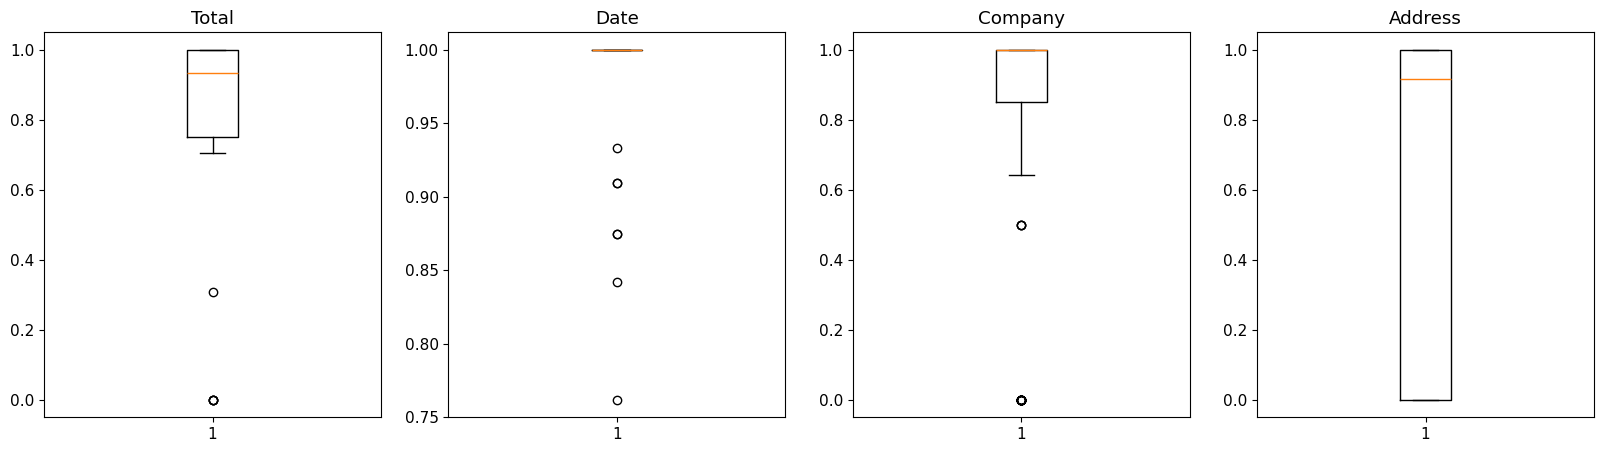

In [9]:
%matplotlib inline

total_lratios = list()
date_lratios = list()
company_lratios = list()
address_lratios = list()

for i in range(len(gt_word_label_tuples)):
    for j in range(len(gt_word_label_tuples[i])):
        
        gt_word = gt_word_label_tuples[i][j][0]
        pred_word, pred_label = preds_word_label_tuples[i][j][0], id2label[preds_word_label_tuples[i][j][1]]

        if pred_label in ['B-TOTAL', 'I-TOTAL']:
            total_lratios.append(ratio( gt_word.lower(), pred_word.lower() ))
            
        elif pred_label in ['B-COMPANY', 'I-COMPANY']:
            company_lratios.append(ratio( gt_word.lower(), pred_word.lower() ))
            
        elif pred_label in ['B-DATE', 'I-DATE']:
            date_lratios.append(ratio( gt_word.lower(), pred_word.lower() ))
            
        elif pred_label in ['B-ADDRESS', 'I-ADDRESS']:
            address_lratios.append(ratio( gt_word.lower(), pred_word.lower() ))
            
        elif pred_label == 'O':
            continue


fig, axes = plt.subplots(ncols=4, figsize=(20, 5))

axes[0].set_title('Total')
axes[0].boxplot(total_lratios)

axes[1].set_title('Date')
axes[1].boxplot(date_lratios)

axes[2].set_title('Company')
axes[2].boxplot(company_lratios)

axes[3].set_title('Address')
axes[3].boxplot(address_lratios);


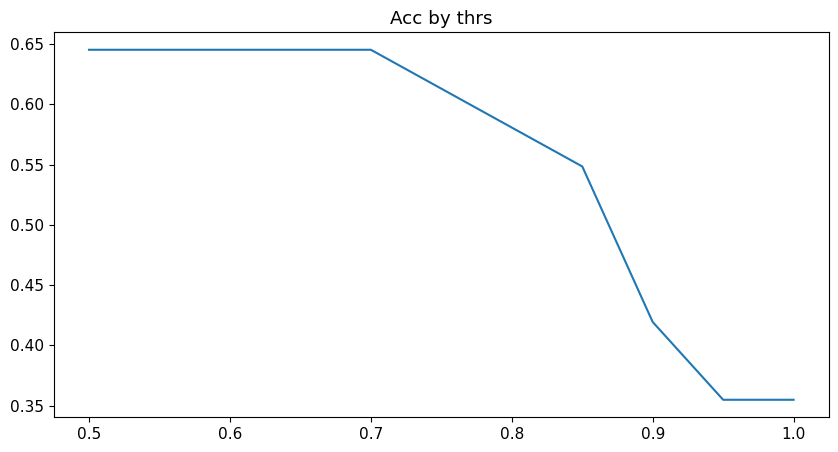

In [32]:


receipts_accuracies = []
lratio_thrs = []

for current_lratio_thr in np.linspace(0.5, 1.0, 11):

    total_lratio_thr = current_lratio_thr
    date_lratio_thr = current_lratio_thr
    other_lratio_thr = current_lratio_thr
    
    total_binary = list()
    date_binary = list()
    company_binary = list()
    address_binary = list()
    
    # receipt is correct if at least one entity is found
    correct_receipts = list()
    
    for i in range(len(gt_word_label_tuples)):
        entities_found = {'company': False, 'address': False, 'total': False, 'date': False}
    
        for j in range(len(gt_word_label_tuples[i])):
    
            gt_word = gt_word_label_tuples[i][j][0]
            pred_word, pred_label = preds_word_label_tuples[i][j][0], id2label[preds_word_label_tuples[i][j][1]]
            
            if pred_label in ['B-TOTAL', 'I-TOTAL']:
                lratio = ratio( gt_word.lower(), pred_word.lower() )
                if lratio >= total_lratio_thr:
                    total_binary.append(1)
                    if not entities_found['total']:
                        entities_found['total'] = True
                else:
                    total_binary.append(0)
                
            elif pred_label in ['B-COMPANY', 'I-COMPANY']:
                lratio = ratio( gt_word.lower(), pred_word.lower() )
                if lratio >= other_lratio_thr:
                    company_binary.append(1)
                    if not entities_found['company']:
                        entities_found['company'] = True
                else:
                    company_binary.append(0)
                
            elif pred_label in ['B-DATE', 'I-DATE']:
                lratio = ratio( gt_word.lower(), pred_word.lower() )
                if lratio >= date_lratio_thr:
                    date_binary.append(1)
                    if not entities_found['date']:
                        entities_found['date'] = True
                else:
                    date_binary.append(0)
                
            elif pred_label in ['B-ADDRESS', 'I-ADDRESS']:
                lratio = ratio( gt_word.lower(), pred_word.lower() )
                if lratio >= other_lratio_thr:
                    address_binary.append(1)
                    if not entities_found['address']:
                        entities_found['address'] = True
                else:
                    address_binary.append(0)
                
            elif pred_label == 'O':
                continue
    
        if all(list(entities_found.values())):
            correct_receipts.append(1)
        else:
            correct_receipts.append(0)

    receipts_accuracies.append(sum(correct_receipts)/len(correct_receipts))
    lratio_thrs.append(current_lratio_thr)
            
    # print(f'total accuracy {sum(total_binary)/len(total_binary):.3f}')
    # print(f'date accuracy {sum(date_binary)/len(date_binary):.3f}')
    # print(f'company accuracy {sum(company_binary)/len(company_binary):.3f}')
    # print(f'address accuracy {sum(address_binary)/len(address_binary):.3f}')
    # print(f'receipt accuracy {sum(correct_receipts)/len(correct_receipts):.3f}') 

plt.figure(figsize=(10,5))
plt.title('Acc by thrs')
plt.plot(lratio_thrs, receipts_accuracies)


In [35]:
current_lratio_thr = 0.75

total_lratio_thr = current_lratio_thr
date_lratio_thr = current_lratio_thr
other_lratio_thr = current_lratio_thr
    
total_binary = list()
date_binary = list()
company_binary = list()
address_binary = list()
    
# receipt is correct if at least one entity is found
correct_receipts = list()


for i in range(len(gt_word_label_tuples)):
    entities_found = {'company': False, 'address': False, 'total': False, 'date': False}
    
    for j in range(len(gt_word_label_tuples[i])):
    
        gt_word = gt_word_label_tuples[i][j][0]
        pred_word, pred_label = preds_word_label_tuples[i][j][0], id2label[preds_word_label_tuples[i][j][1]]
            
        if pred_label in ['B-TOTAL', 'I-TOTAL']:
            lratio = ratio( gt_word.lower(), pred_word.lower() )
            if lratio >= total_lratio_thr:
                total_binary.append(1)
                if not entities_found['total']:
                    entities_found['total'] = True
            else:
                total_binary.append(0)
                
        elif pred_label in ['B-COMPANY', 'I-COMPANY']:
            lratio = ratio( gt_word.lower(), pred_word.lower() )
            if lratio >= other_lratio_thr:
                company_binary.append(1)
                if not entities_found['company']:
                    entities_found['company'] = True
            else:
                company_binary.append(0)
                
        elif pred_label in ['B-DATE', 'I-DATE']:
            lratio = ratio( gt_word.lower(), pred_word.lower() )
            if lratio >= date_lratio_thr:
                date_binary.append(1)
                if not entities_found['date']:
                    entities_found['date'] = True
            else:
                date_binary.append(0)
                
        elif pred_label in ['B-ADDRESS', 'I-ADDRESS']:
            lratio = ratio( gt_word.lower(), pred_word.lower() )
            if lratio >= other_lratio_thr:
                address_binary.append(1)
                if not entities_found['address']:
                    entities_found['address'] = True
            else:
                address_binary.append(0)
                
        elif pred_label == 'O':
            continue
    
    if all(list(entities_found.values())):
        correct_receipts.append(1)
    else:
        correct_receipts.append(0)

receipts_accuracies.append(sum(correct_receipts)/len(correct_receipts))
lratio_thrs.append(current_lratio_thr)
            
print(f'total accuracy {sum(total_binary)/len(total_binary):.3f}')
print(f'date accuracy {sum(date_binary)/len(date_binary):.3f}')
print(f'company accuracy {sum(company_binary)/len(company_binary):.3f}')
print(f'address accuracy {sum(address_binary)/len(address_binary):.3f}')
print(f'receipt accuracy {sum(correct_receipts)/len(correct_receipts):.3f}')

total accuracy 0.759
date accuracy 1.000
company accuracy 0.766
address accuracy 0.669
receipt accuracy 0.613
